In [1]:
import torch
from torch.utils.data import Dataset

import numpy as np

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import torch

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.device(0)

torch.cuda.get_device_name(1)

'NVIDIA GeForce RTX 3090'

In [7]:
model_data_filenames_dict = catalog.load("center_out_model_spectrogram_indices")
trial_loading_dict = catalog.load("center_out_model_spectrogram_std_pkl")

[12/06/22 09:31:54] INFO     Loading data from 'center_out_model_spectrogram_indices'           ]8;id=261170;file:///home/sshah/bci-pipeline/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=541362;file:///home/sshah/bci-pipeline/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

                    INFO     Loading data from 'center_out_model_spectrogram_std_pkl'           ]8;id=602884;file:///home/sshah/bci-pipeline/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=365802;file:///home/sshah/bci-pipeline/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (PartitionedDataSet)...                                                               

In [8]:
import numpy as np

In [9]:
model_data_filenames = catalog.load("center_out_model_filenames")
model_data_filenames = np.array(model_data_filenames)

[12/06/22 09:31:55] INFO     Loading data from 'center_out_model_filenames' (PickleDataSet)...  ]8;id=148458;file:///home/sshah/bci-pipeline/lib/python3.8/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=472927;file:///home/sshah/bci-pipeline/lib/python3.8/site-packages/kedro/io/data_catalog.py#343\343]8;;\

In [10]:
model_data_params = context.params['model_data_params']

pre_stimulus_time = model_data_params['pre_stimulus_time']
post_completion_time = model_data_params['post_completion_time']

window_size = model_data_params['window_size']
shift = model_data_params['shift']

current_experiment = context.params['current_experiment']
sessions = context.params['sessions']
patient_id = context.params['patient_id']

In [11]:
def _generate_trial_filenames_list(model_data_filenames_dict):
    trial_filenames_list = []
    for partition_key, partition_data_func in model_data_filenames_dict.items():
        model_data_dict = partition_data_func()

        for state, trial_information_dict in model_data_dict.items():
            session_type = trial_information_dict['session_type']
            date = trial_information_dict['date']
            local_trials_idx_list = trial_information_dict['local_trials_idx_list']
            session = trial_information_dict['session']

            trial_filenames_list += [f"{session_type}_{date}_{session}_T{trial_idx}_state{state}" for trial_idx in local_trials_idx_list]
            
    return trial_filenames_list

In [12]:
def _generate_train_test_split_indices(model_data_filenames_dict, model_data_filenames, model_data_params, current_experiment):
    data_split_type = model_data_params[current_experiment]['sel_split_type']

    split_type_params = model_data_params[current_experiment]['split_types'][data_split_type]

    leave_out = split_type_params['leave_out']
    randomized = split_type_params['randomized']
    random_seed = split_type_params['random_seed']
    sel_session_type = model_data_params[current_experiment]['sel_session_type']

    np.random.seed(random_seed)

    if data_split_type == 'leave_day_out':
        dates_list = []
        for partition_key, partition_data_func in model_data_filenames_dict.items():
            date = partition_key.split('_')[-2]
            session = partition_key.split('_')[-1]
            
            data_dict = partition_data_func()
            
            for state, trial_information_dict in data_dict.items():
                if sel_session_type != trial_information_dict['session_type']:
                    break
                
                if date not in dates_list:
                    dates_list.append(date)
                    break
        
        dates_list = np.array(list(set(dates_list)))

        dates_list_permuted = dates_list
        if randomized:
            dates_list_permuted = np.random.permutation(dates_list)

        test_list_dates = dates_list_permuted[:leave_out]
        train_list_dates = dates_list_permuted[leave_out:]
        
        train_list = []
        test_list = []
        train_labels_list = []
        test_labels_list = []
        for partition_key, partition_data_func in model_data_filenames_dict.items():
            date = partition_key.split('_')[-2]
            session = partition_key.split('_')[-1]
            
            data_dict = partition_data_func()
            
            for state, trial_information_dict in data_dict.items():
                session_type = trial_information_dict['session_type']
                
                if sel_session_type != session_type:
                    continue
                
                if date in train_list_dates:
                    train_list += trial_information_dict['global_trials_idx_list']
                    train_labels_list += [state]*len(trial_information_dict['global_trials_idx_list'])
                    
                elif date in test_list_dates:
                    test_list += trial_information_dict['global_trials_idx_list']
                    test_labels_list += [state]*len(trial_information_dict['global_trials_idx_list'])

    elif data_split_type == 'leave_session_out':
        dates_and_sessions_list = []
        for partition_key, partition_data_func in model_data_filenames_dict.items():
            date = partition_key.split('_')[-2]
            session = partition_key.split('_')[-1]
            
            data_dict = partition_data_func()
            
            for state, trial_information_dict in data_dict.items():
                if sel_session_type != trial_information_dict['session_type']:
                    break
                
                if {'date': date, 'session': session} not in dates_and_sessions_list:
                    dates_and_sessions_list.append({'date': date, 'session': session})
                    break

        dates_and_sessions_list = np.array(dates_and_sessions_list)

        dates_and_sessions_list_permuted = dates_and_sessions_list
        if randomized:
            dates_and_sessions_list_permuted = np.random.permutation(dates_and_sessions_list)
        
        test_list_dates_and_sessions = dates_and_sessions_list_permuted[:leave_out]
        train_list_dates_and_sessions = dates_and_sessions_list_permuted[leave_out:]
        
        train_list = []
        test_list = []
        train_labels_list = []
        test_labels_list = []
        for partition_key, partition_data_func in model_data_filenames_dict.items():
            date = partition_key.split('_')[-2]
            session = partition_key.split('_')[-1]
            
            data_dict = partition_data_func ()
            for state, trial_information_dict in data_dict.items():
                if {'date': date, 'session': session} in train_list_dates_and_sessions:
                    train_list += trial_information_dict['global_trials_idx_list']
                    train_labels_list += [state]*len(trial_information_dict['global_trials_idx_list'])
                    
                elif {'date': date, 'session': session} in test_list_dates_and_sessions:
                    test_list += trial_information_dict['global_trials_idx_list']
                    test_labels_list += [state]*len(trial_information_dict['global_trials_idx_list'])

    elif data_split_type == 'leave_trial_out':
        trials_list = []
        labels_list= []
        for partition_key, partition_data_func in model_data_filenames_dict.items():
            date = partition_key.split('_')[-2]
            session = partition_key.split('_')[-1]
            
            data_dict = partition_data_func()
            
            for state, trial_information_dict in data_dict.items():
                if sel_session_type != trial_information_dict['session_type']:
                    break
                    
                trials_list += trial_information_dict['global_trials_idx_list']
                labels_list += [state]*len(trial_information_dict['global_trials_idx_list'])

        trials_list = np.array(trials_list)
        labels_list = np.array(labels_list)

        permutation_indices = np.arange(len(labels_list))
        if randomized:
            permutation_indices = np.random.permutation(permutation_indices)

        trials_list_permuted = trials_list[permutation_indices]
        trials_labels_list_permuted = labels_list[permutation_indices]
        
        test_list = trials_list_permuted[:leave_out]
        train_list = trials_list_permuted[leave_out:]

        test_labels_list = trials_labels_list_permuted[:leave_out]
        train_labels_list = trials_labels_list_permuted[leave_out:]

    
    return {
        'train_list_idx': np.array(train_list),
        'test_list_idx': np.array(test_list),
        'train_labels_list': np.array(train_labels_list),
        'test_labels_list': np.array(test_labels_list),
        'train_filenames': model_data_filenames[np.array(train_list)],
        'test_filenames': model_data_filenames[np.array(test_list)]
    }

In [13]:
train_test_indices_dict = _generate_train_test_split_indices(model_data_filenames_dict, model_data_filenames, model_data_params, current_experiment)

train_list_idx = train_test_indices_dict['train_list_idx']
test_list_idx = train_test_indices_dict['test_list_idx']
train_labels_list = train_test_indices_dict['train_labels_list'] 
test_labels_list = train_test_indices_dict['test_labels_list']

train_filenames = model_data_filenames[train_list_idx]
test_filenames = model_data_filenames[test_list_idx]

In [97]:
window_size

10

In [14]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

def _window_spectrogram(sxx, shift, window_size):
    
    return np.moveaxis(sliding_window_view(sxx, window_shape=window_size, axis=1), [0, -1], [1, -2])[::shift, ...]

In [15]:
class CorticomExperimentDataset(Dataset):
    def __init__(self, trial_filenames_dict, trial_labels_list, trial_loading_dict):
        self.trial_filenames_dict = trial_filenames_dict
        self.trial_labels_list = trial_labels_list
        self.trial_loading_dict = trial_loading_dict

    def __len__(self):
        return len(self.trial_filenames_dict)

    def __getitem__(self, idx):
        filename = self.trial_filenames_dict[idx]
        
        return self.trial_loading_dict[filename](), self.trial_labels_list[idx]

In [16]:
# Create training and testing PyTorch datasets
training_dataset = CorticomExperimentDataset(train_filenames, train_labels_list, trial_loading_dict)
testing_dataset = CorticomExperimentDataset(test_filenames, test_labels_list, trial_loading_dict)

In [98]:
def experiment_dataloader_collate(data):
    sxx_list = []
    labels_list = []
    
    for sxx, label in data:
        windowed_sxx = _window_spectrogram(sxx, shift, window_size)
        
        sxx_list.append(windowed_sxx)
        
        print(sxx.shape)
        print(windowed_sxx.shape)
        
        labels_list += [label]*windowed_sxx.shape[0]
    
    windowed_sxx = np.concatenate(sxx_list)
    labels_sxx = np.array(labels_list) - 1
    
    return windowed_sxx, labels_sxx

In [99]:
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=3, shuffle=True, collate_fn=experiment_dataloader_collate)

In [100]:
batch, labels = next(iter(training_loader))

(129, 525, 128)
(516, 129, 10, 128)
(129, 527, 128)
(518, 129, 10, 128)
(129, 525, 128)
(516, 129, 10, 128)


In [90]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchinfo import summary

In [91]:
# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(10, 10, (1,11), stride=(1,1), bias=False)
        self.conv2 = nn.Conv2d(10, 10, (1,11), stride=(1,1), bias=False )
        self.conv3 = nn.Conv2d(10, 10, (1,11), stride=(1,1), bias=False)
        self.conv4 = nn.Conv2d(10, 10, (1,7), stride=(1,1), bias=False)
        # self.conv5 = nn.Conv2d(10, 10, (1,3), stride=(1,1), bias=False)
        
        self.conv1d1 = nn.Conv1d(10, 10, 11, stride=1, bias=False)
        self.conv1d2 = nn.Conv1d(10, 10, 11, stride=1, bias=False)
        
        # self.lstm = nn.LSTM(128, 64, batch_first=True, bias=False)
        # self.lstm2 = nn.LSTM(64, 32, batch_first=True, bias=False)
        
        self.pool = nn.MaxPool2d((1, 2), (1, 2))
        self.pool1d = nn.MaxPool1d(2, 2)
        self.fc1 = nn.Linear(240, 120, bias=False)
        self.fc2 = nn.Linear(120, 8, bias=False)
        
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = torch.moveaxis(x, (1, 3), (3, 2))
        x = F.elu(self.conv1(x))
        x = self.pool(x)
        x = F.elu(self.conv2(x))
        x = self.pool(x)
        x = F.elu(self.conv3(x))
        x = self.pool(F.elu(x))
        x = self.conv4(x)
        # x = self.pool(F.elu(x))
        # x = F.elu(self.conv5(x))
        x = torch.squeeze(x, dim=-1)
        
        x = self.pool1d(F.elu(self.conv1d1(x)))
        x = self.pool1d(F.elu(self.conv1d2(x)))
        
        
        # x = self.lstm(x)
        # x = x[0]
        # x = self.lstm2(x)
        # x = x[0][:, -1, :]
        x = x.reshape(-1, 240)
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        # x = self.softmax(x)
        return x

model = GarmentClassifier()
model = model.to(device)

In [92]:
summary(model, input_size=(1, 129, 10, 128))

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GarmentClassifier                        [1, 8]                    --
├─Conv2d: 1-1                            [1, 10, 128, 119]         1,100
├─MaxPool2d: 1-2                         [1, 10, 128, 59]          --
├─Conv2d: 1-3                            [1, 10, 128, 49]          1,100
├─MaxPool2d: 1-4                         [1, 10, 128, 24]          --
├─Conv2d: 1-5                            [1, 10, 128, 14]          1,100
├─MaxPool2d: 1-6                         [1, 10, 128, 7]           --
├─Conv2d: 1-7                            [1, 10, 128, 1]           700
├─Conv1d: 1-8                            [1, 10, 118]              1,100
├─MaxPool1d: 1-9                         [1, 10, 59]               --
├─Conv1d: 1-10                           [1, 10, 49]               1,100
├─MaxPool1d: 1-11                        [1, 10, 24]               --
├─Linear: 1-12                           [1, 120]                  28,800
├─Linear: 1-13                           [1, 8]                    960
==========================================================================================
Total params: 35,960
Trainable params: 35,960
Non-trainable params: 0
Total mult-adds (M): 25.93
==========================================================================================
Input size (MB): 0.66
Forward/backward pass size (MB): 1.89
Params size (MB): 0.14
Estimated Total Size (MB): 2.69
==========================================================================================

In [93]:
loss_fn = torch.nn.CrossEntropyLoss()

In [94]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [95]:
import sys

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    
#     for i in notebook.tqdm(range(2), desc='Training Loop'):
#         sleep(1)
#         # tqdm.write(f"\rDone task {i}")
#         sys.stdout.write(f"\rDone task {i}")
#         sys.stdout.flush()
    
    for i, data in enumerate(notebook.tqdm(training_loader)):
        # Every data instance is an input + label pair
        inputs, labels = data
        
        labels_pyt = torch.from_numpy(labels).type(torch.float).to(device)
        inputs_pyt = torch.from_numpy(inputs).type(torch.float).to(device)
        
        len_batch = labels_pyt.shape[0]
        
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        
        # print("Hello")

        # Make predictions for this batch
        outputs = model(inputs_pyt)
        
        # print("Hillo")
        
        _, pred = torch.max(outputs, 1)
        
        # print(inputs_pyt[0, 0, 0, 0])
        # print(inputs_pyt[-1, 0, 0, 0])
        
        # print(outputs[:2, :])
        
        # print(pred)
        # print(labels_pyt)
        
        sys.stdout.write(f"\r{(pred==labels_pyt).sum()/len(pred)*100:.5f}% | ")
        
        sys.stdout.write(f"{torch.unique(pred)} | ")
        
        # print(outputs.shape)
        # print(outputs.type())
        # print(labels_pyt.type())

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels_pyt.long())
        # print(loss)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        # if i % 10 == 0:
        last_loss = running_loss / len_batch # loss per batch
        sys.stdout.write(f'batch {i + 1} loss: {loss:.5f}')
        # tb_x = epoch_index * len(training_loader) + i + 1
        # tb_writer.add_scalar('Loss/train', last_loss, tb_x)
        running_loss = 0.
        
        sys.stdout.flush()

    return last_loss

In [96]:
from tqdm import tqdm, notebook
from time import sleep

# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
# writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('\rEPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number)

    # We don't need gradients on to do reporting
    model.train(False)

#     running_vloss = 0.0
#     for i, vdata in enumerate(validation_loader):
#         vinputs, vlabels = vdata
#         voutputs = model(vinputs)
#         vloss = loss_fn(voutputs, vlabels)
#         running_vloss += vloss

#     avg_vloss = running_vloss / (i + 1)
#     print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    # writer.add_scalars('Training vs. Validation Loss',
    #                 { 'Training' : avg_loss, 'Validation' : avg_vloss },
    #                 epoch_number + 1)
    # writer.flush()

    # Track best performance, and save the model's state
    # if avg_vloss < best_vloss:
    #     best_vloss = avg_vloss
    #     model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    #     torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH 2:% | tensor([6], device='cuda:0') | batch 200 loss: 2.04848520: 2.07101


  0%|          | 0/200 [00:00<?, ?it/s]

EPOCH 3: | tensor([1, 3], device='cuda:0') | batch 200 loss: 2.092246937183.07596


  0%|          | 0/200 [00:00<?, ?it/s]

0.00000% | tensor([3, 7], device='cuda:0') | batch 26 loss: 2.13924

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_299458/2778962641.py:17 in <cell line: 12>                                        │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_299458/2778962641.py'                       │
│                                                                                                  │
│ /tmp/ipykernel_299458/1303677725.py:46 in train_one_epoch                                        │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_299458/1303677725.py'                       │
│                                                                                                  │
│ /home/sshah/bci-pipeline/lib/python3.8/site-packages/torch/_tensor.py:857 in __format__          │
│                                                                                                  │
│    854 │   │   if has_torch_function_unary(self):                                                │
│    855 │   │   │   return handle_torch_function(Tensor.__format__, (self,), self, format_spec)   │
│    856 │   │   if self.dim() == 0 and not self.is_meta and type(self) is Tensor:                 │
│ ❱  857 │   │   │   return self.item().__format__(format_spec)                                    │
│    858 │   │   return object.__format__(self, format_spec)                                       │
│    859 │                                                                                         │
│    860 │   @_handle_torch_function_and_wrap_type_error_to_not_implemented                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [49]:
import sys

for idx, i in enumerate(notebook.tqdm(range(2), desc='Training Loop')):
    sleep(1)
    # tqdm.write(f"\rDone task {i}")
    sys.stdout.write(f"\rDone task {idx} {i}")
    sys.stdout.write(f"Done task {idx} {i}")
    sys.stdout.flush()

Training Loop:   0%|          | 0/2 [00:00<?, ?it/s]

Done task 1 1Done task 1 1

In [154]:
len(training_loader)

300

In [149]:
import sys
import time

for f in range(10):
    #delete "\r" to append instead of overwrite
    sys.stdout.write("\r" + str(f))
    sys.stdout.flush()
    time.sleep(1)

9

In [ ]:
torch.from_numpy()

In [278]:
model.conv1.weight.long().type()

'torch.LongTensor'

In [189]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=4, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


Dress  T-shirt/top  Coat  T-shirt/top


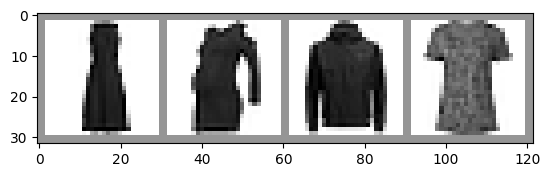

In [190]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [194]:
labels.type(torch.float).type()

'torch.FloatTensor'

In [121]:
torch.tensor([1,2,3])

tensor([1, 2, 3])